# Section 9 - CIFAR 10 with Convolutional Neural Networks(CNN) - PyTorch

# PyTorch Instalation

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

## Initializing GPU Usage

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")         # Analyzing GPU availability

## Making and Configuring the dataset

> ### Some explanations...
> - ***Tensors for images***: [(BatchIndex, NumberOfChannels, ImagesHeight, ImagesWidth)] -> [(BI, C, H, W)].
> - ***transforms.Resize((28,28))***: 
> - ***transforms.ToTensor()***: Convert the numpy array, in this case an image, to a float tensor format;
> - ***transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))***: Normalize the values of each channel of the tensor image. The first set of brackets is the mean and in the second set of brackets is the standard deviation. For images with 3 channels of color.
> - ***transforms.RandomHorizontalFlip()***: Horizontal flip the given PIL Image randomly with a given probability.
> - ***transforms.RandomRotation(10)***: Rotate the image by angle.
> - ***transforms.RandomAffine(0, shear=10, scale=(0.8,1.2))***: Random affine transformation of the image keeping center invariant.
> - ***transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)***: Randomly change the brightness, contrast and saturation of an image.


> - ***training_dataset and validation_dataset***: Load the train and validation MNIST dataset from torchvision datasets. The load is done downloading the dataset and saving in the root directory;
> - ***training_loader and validation_loader***: A training loader and validation loader are what we use to specify the training batches. In MNIST dataset, there are 60000 images for training. It can be too much images to load at once in the computer memory, so it is better to use image batches in the training process. For every Epoch, is performed a singles pass through the entire dataset and it occurs in batches;
> - ***NumberOfBatches*** = DatasetSize/BatchSize

In [0]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

0it [00:00, ?it/s]

170500096it [00:06, 27729870.48it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
# This function converts an image from tensor format to numpy format.
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

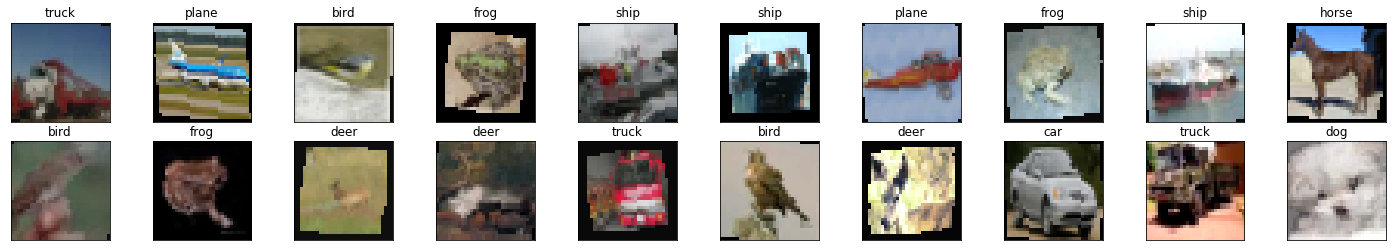

In [0]:
# Plot some images from the first batch.
# iter() -> Create an object that allows us to go through the iterable training_loader, one element at a time. 
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

## Making and Configuring the CNN - Model Class Constructor

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

> ### The ***CrossEntropyLoss*** is used for ***MULTICLASS*** classification problems. It is a combination between ***log_softmax*** and ***NLLLoss***.

> ### ***OBS***: When the criterion used is the CrossEntropyLoss, in the end of the CNN, an Activation Function is not used. The last layer is not an Activation Function. The inputs for CrossEntropyLoss are the raw scores and internaly the Softmax Activation Function is applied.

In [0]:
criterion = nn.CrossEntropyLoss()

> ### The Adam Optimization Algorithm is a combination of two other extensions of Stochastic Gradiente Descent: *Adagrad* and *RMSprop*. The Adam Optimization Algorithm computes adaptive learning rates for each parameters instead of keep the same learning rates for all parameters.


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Executing the ***TRAIN*** step of the CNN

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6796, acc 38.0880 
validation loss: 1.3875, validation acc 49.7500 
epoch : 2
training loss: 1.3968, acc 49.5480 
validation loss: 1.2789, validation acc 53.9200 
epoch : 3
training loss: 1.2654, acc 54.6840 
validation loss: 1.1339, validation acc 59.6000 
epoch : 4
training loss: 1.1737, acc 58.2540 
validation loss: 1.0509, validation acc 62.7300 
epoch : 5
training loss: 1.1041, acc 61.0440 
validation loss: 0.9734, validation acc 65.7600 
epoch : 6
training loss: 1.0529, acc 62.6740 
validation loss: 0.9377, validation acc 66.7300 
epoch : 7
training loss: 1.0106, acc 64.4460 
validation loss: 0.9018, validation acc 68.3500 
epoch : 8
training loss: 0.9788, acc 65.6300 
validation loss: 0.8839, validation acc 69.1900 
epoch : 9
training loss: 0.9458, acc 66.8140 
validation loss: 0.8522, validation acc 70.3500 
epoch : 10
training loss: 0.9254, acc 67.6200 
validation loss: 0.8525, validation acc 70.4100 
epoch : 11
training loss: 0.8996, acc 68.4000 
va

> ## *Overfitting*: is when the model starts to memorize the training dataset but starts to fail in generalize to new data.
> ### If the epoch number is increased too much, the training loss starts to become higher than the validation loss, this is a signal that the model starts to Overfitting.

> ### Ways to prevent Overfitting of the model:
- ***Hyperparameter Tunning***: Adjusting some Hyperparameters like:
  - ***Learning Rate***
  - ***Data Augmentation***: This is the process by witch we create new data for our model to use during training process. This is done by taking our the existing training dataset and transforming or altering the images in useful ways to create new images. 
  - ***Increasing the number of Convolution Layers***
- ***Use Dropout Technique***: Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. This force the remaining hidden layers and neurons to learn(weight updates) and result in a good performance. This technique helps in the generalization of the model.
  - ***Dropout Layers(nn.Dropout())***: Is used in between layers that have high number of parameters because this high parameters layers are more likely to overfit and memorize the training data.
- ***Decrease the kernel's size***: Decreasing the kernel's size there will be less weights to update.

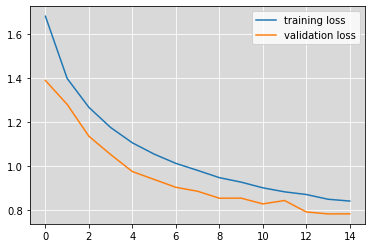

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)

plt.legend()
# If the epoch number is increased too much, the training loss starts to become higher than the validation loss, this is a signal that the model starts to Overfitting.
# A model with Overfitting is when the model starts to memorize the training dataset but starts to fail in generalize to new data.

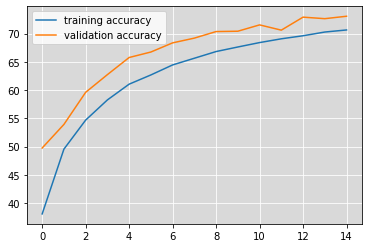

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)

plt.legend()

## Executing the ***PREDICT*** step of the CNN

*italicized text*> ### For this step, an image from the internet is downloaded and submitted to the model as an image test. 

In [0]:
!pip3 install pillow==4.0.0

     |████████████████████████████████| 5.6MB 6.4MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
import PIL.ImageOps

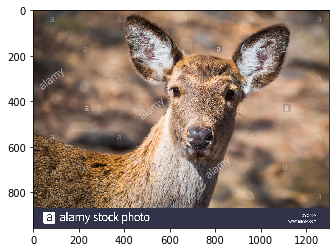

In [0]:
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

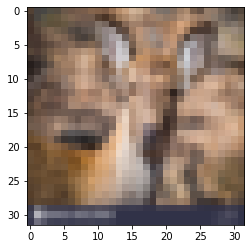

In [0]:
img = transform(img) 
plt.imshow(im_convert(img))

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

cat


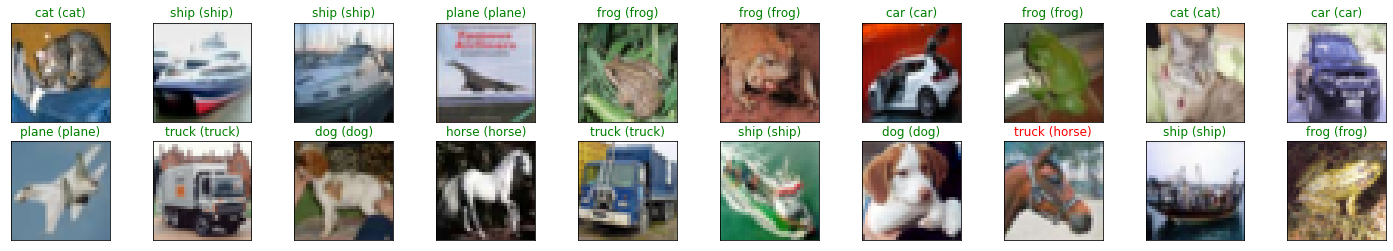

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))